In [1]:
import warnings
from pathlib import Path

import gensim

# Widgets
import ipywidgets as widgets
import nltk
import pandas as pd
import pyLDAvis.gensim_models
import seaborn as sns
import spacy
from gensim import corpora
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
from ipywidgets import interact
from matplotlib import pyplot as plt
from nltk.corpus import stopwords

# Pakete für NLP
from wordcloud import WordCloud
from ydata_profiling import ProfileReport

InteractiveShell.ast_node_interactivity = "all"

nltk.download("stopwords")  # start the NLTK Downloader and download the stopwords
warnings.filterwarnings("ignore")

F:\Basti\Studium\HSHarz\Analyse von Finanzdaten\.venv\Lib\site-packages\visions\utils\monkeypatches\imghdr_patch.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  from imghdr import tests
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# LDA and WordCloud on Mastodon Posts for the Bavarian State Election!

## Loading the data from Parquet File

We only share a limited set of parameters. Especially no usernames, or server local user ids, no user tags and so on. For anonymization, we only share the limited set of parameters, that is need to execute this notebook.

We selected a party as the dominant party, when this party or its candidate was mentioned 50 % or more compared to other parties. But this results in many posts that mention the candidates Söder, Aiwanger, although the post is attribute to different parties. This mixed attribution, which allows to mention different parties as long as there is a clear dominant party, makes attribution hard, but was used to keep as many posts as possible. 
Even though in some weeks we did not record post for some smaller "dominant" parties.

In addition, the state election in Hessia, was held on the same day, which also mentioned in some posts.


In [2]:
toots_path = Path() / "german_toots_small.pqt"
german_sentiment_df = pd.read_parquet(toots_path)
german_sentiment_df = german_sentiment_df[german_sentiment_df.date > pd.to_datetime("2023-9-1")]
german_sentiment_df

,date,day,week,mentioned_party,dominant_party,cleared_content,sentiment
735,2023-09-01 00:27:55,244,35,csu,csu,jan buehlbecker AhaAchja dann veranstaltet söd...,-0.000032
736,2023-09-01 00:23:27,244,35,fw,fw,Der Antisemitismusbeauftragte der Bundesregier...,-0.000027
737,2023-09-01 00:17:34,244,35,fw,fw,Das dem Herrn Aiwanger nach mehreren Tagen imm...,-0.989762
738,2023-09-01 00:00:08,244,35,fw,fw,"'Aktuell wichtiger denn je. Gell, Hubsi…😇 ' Ai...",-0.543437
739,2023-09-01 03:55:45,244,35,fw,fw,"Habe gerade im Deutschlandfunk gehört, dass au...",-0.011672
...,...,...,...,...,...,...,...
5596,2023-11-18 19:00:36,322,46,afd,afd,RT by TerryReintke : Eine überfallartig gekape...,-0.002703
5597,2023-11-18 20:08:06,322,46,afd,afd,"MuHa, großdeutscher AfD - NAZIPuff im bayrisch...",-0.427801
5598,2023-11-18 20:55:02,322,46,linke,linke,risa spirelli mich nervt es auch das man kaum ...,-0.986509
5599,2023-11-18 22:04:01,322,46,fdp,fdp,"BerlinVic Es gibt zu viele Leute, die sie wähl...",-0.010498


Use the German StopWords from NLTK

In [3]:
# remove stopwords
nltk_stop_words = set(stopwords.words("german"))  # Selecting nltk stopwords
len(nltk_stop_words)

232

Also use the German StopWords form Spacy.
Install the llematizer with:
`python -m spacy download de_core_news_lg`

In [4]:
nlp = spacy.load("de_core_news_lg")
spacy_stop_words = set(nlp.Defaults.stop_words)
len(spacy_stop_words)

543

Add some costume stop words with special characters and common verbs.

In [5]:
extra_stop_words = {
    "wird",
    "war",
    "werden",
    "hat",
    "haben",
    "nicht",
    "ist",
    "sind",
    "sein",
    "steht",
    "mal",
    "machen",
    "können",
    "ein",
    "einen",
    "noch",
    "da",
    "amp",
    "bleiben",
    "finden",
    "geben",
    "  ",
    " ",
    "",
    "”",
    "+",
    "--",
    "*",
    "&",
    "|",
    "[",
    "]",
    "/",
    "%",
    "'",
    "´´",  # noqa: RUF001
    '"',
}
stop_words = nltk_stop_words | spacy_stop_words | extra_stop_words
len(stop_words)

589

Convert the text in each row in a list opf words and exclude stopwords.

In [6]:
german_sentiment_without_stop_words = german_sentiment_df.cleared_content.apply(
    lambda text: " ".join([word.strip() for word in text.lower().split(" ") if word.strip() not in stop_words])
)
german_sentiment_without_stop_words

735     jan buehlbecker ahaachja veranstaltet söder ko...
736     antisemitismusbeauftragte bundesregierung, fel...
737     herrn aiwanger mehreren bitte entschuldigung d...
738     'aktuell wichtiger je. gell, hubsi…😇 aiwanger ...
739     deutschlandfunk gehört, bbc fall aiwanger beri...
                              ...                        
5596    rt by terryreintke : überfallartig gekaperte p...
5597    muha, großdeutscher afd - nazipuff bayrischen ...
5598    risa spirelli nervt streiten und/oder will. bl...
5599    berlinvic leute, wählen, gemeinsam wähnen. fdp...
5600    linke trifft augsburg erneuerung , globale ger...
Name: cleared_content, Length: 4603, dtype: object

## Word Cloud after Removing StopWords

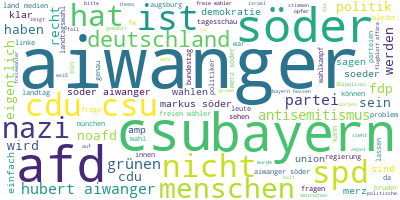

In [7]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
long_string = ",".join(german_sentiment_without_stop_words)
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=5, contour_color="steelblue")
wordcloud.generate(long_string)
wordcloud.to_image()

## Word Cloud after Lemmatize
Lemmatize with Spacy (https://spacy.io/models/de). Spacy uses models small to large and a BERT based model. We use *large*. 
This has to be installed via *pip* see link.
NLTK WORDNET does not work with the German language. 

In [8]:
data_words = []

for words in german_sentiment_without_stop_words:
    doc = nlp(words.lower())
    data_words.append([x.lemma_.lower() for x in doc])

# filter for stopwords after lemmatizing again, just to make sure
data_words = [[x for x in data_word if x not in stop_words] for data_word in data_words]
german_sentiment_df["lemma"] = data_words

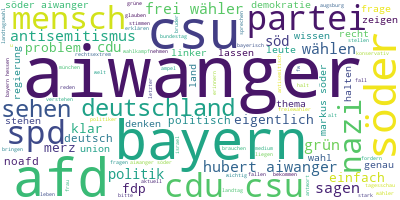

In [9]:
long_string = ",".join([x for data_word in data_words for x in data_word])
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=5, contour_color="steelblue")
wordcloud.generate(long_string)
wordcloud.to_image()

The Wordcloud shows, that the candidate Hubert Aiwanger and Markus Söder were most important, as their parties Freie Wähler, CDU/CSU (Union) and the party AFD. 

In addition, the words Nazi and Antisemitismus were frequently used. Also, the name of the state `Bayern` was very frequent. But we had a regional filter criteria, so that the post had to name the state name, or that of any other local entity at any local government level or candidate name.

## WordClouds for each Party
The word cloud of each party can be selected with the drop box.

| party                 | support | noteworthy frequent terms              |
|-----------------------|--------:|:---------------------------------------|
| AFD                   |     609 | `rechtsextrem`                         |
| CSU                   |    1570 | `Söder`                                |
| FDP                   |      94 | `Ampel`, `fliegen` and `grün`          |
| Freie Wähler          |    2015 | `Hubert Aiwanger`                      |
| Bündnis 90/Die Grünen |      54 | `Hartmann`, `Grün`, `Bayern`, `Frau`   |
| SPD                   |     192 | `Bayern`, `Hessen`, `Israel`           |
| Die Linke             |      69 | `dropbox`, `ordner` and `icloud drive` |

CSU and Freie Wähler posts mention their candidates very often. These posts attributed to other parties are more diverse. The posts attributed to  `Die Linke` mention exchange directories. FDP posts seam to be more about the national government (`Ampel`).  The few posts about the part `Die Grüne` are the only ones to mention the term Frau (woman) often!

In [10]:
texts = german_sentiment_df.set_index("dominant_party").lemma
party_texts = {}
for i, v in texts.items():
    if i not in party_texts:
        party_texts[i] = [v]
    else:
        party_texts[i].append(v)
parties = set(german_sentiment_df.dominant_party)

# Create Widgets
w_party = widgets.Select(
    options=sorted(parties),
    value="csu",
    description="Party:",
    disabled=False,
)


def update(selected_party: str) -> None:
    """Event to recompute the LDA when updating the number of TOPIC and the party."""
    print(f"Selected Party: {selected_party}")

    party_long_text = ",".join([word for text in party_texts[selected_party] for word in text])
    wc = WordCloud(background_color="white", max_words=100, contour_width=5, contour_color="steelblue").generate(
        party_long_text
    )
    image = wc.to_image()

    # Create a figure and axis using Matplotlib
    fig, ax = plt.subplots(figsize=(10, 10))

    # Display the image on the axis
    ax.imshow(image)

    # Set the title
    ax.set_title(f"{selected_party.upper()} - {len(party_texts[selected_party])} posts", fontsize=20, fontweight="bold")
    # Hide the axis
    ax.axis("off")
    display(plt.show())


interact(update, selected_party=w_party)

interactive(children=(Select(description='Party:', index=1, options=('afd', 'csu', 'fdp', 'fw', 'gruene', 'lin…

<function __main__.update(selected_party: str) -> None>

In [11]:
# Quelle: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# filter words that show up less than 15 times, more than 50% of the time and keep it to 10.000 Words
id2word.filter_extremes(no_below=15, no_above=0.50, keep_n=10000)

# Create Corpus
texts = data_words

# Term Document Frequency
# Converts a collection of words to  a list of (word_id, word_frequency) 2-tuples.
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
def get_model(
    _corpus: list, _id2word: corpora.Dictionary, _num_topics: int, random_state: float = 0
) -> gensim.models.LdaModel:
    """Get a Multicore Variant of the LDA-Model."""
    return gensim.models.LdaMulticore(
        corpus=_corpus, id2word=_id2word, num_topics=_num_topics, random_state=random_state
    )

In [13]:
num_topics = 10
lda_model = get_model(_corpus=corpus, _id2word=id2word, _num_topics=num_topics, random_state=2)
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.023364 -0.010384       1        1  14.442408
0     -0.000316 -0.020678       2        1  11.186186
6     -0.060326  0.005708       3        1  10.871483
9      0.046593  0.016971       4        1  10.491647
7      0.032778 -0.023333       5        1   9.544002
8     -0.009307  0.001001       6        1   9.235980
4      0.007276 -0.007028       7        1   9.016348
3      0.033803  0.001697       8        1   8.978092
2     -0.018461 -0.039355       9        1   8.497972
1     -0.008676  0.075400      10        1   7.735882, topic_info=         Term         Freq        Total Category  logprob  loglift
71        afd   856.000000   856.000000  Default  30.0000  30.0000
1    aiwanger  2526.000000  2526.000000  Default  29.0000  29.0000
201    bayern  1022.000000  1022.000000  Default  28.0000  28.0000
139      merz   373.000000   373.000000  

In [14]:
pyLDAvis.enable_notebook()

In [15]:
document_topics = list(lda_model.get_document_topics(corpus))


def get_main_topic(doc: list) -> int:
    """
    Get the topic index/number for the current document.

    Strongest topic in current document `doc`.
    """
    return max(doc, key=lambda x: x[1])[0]


german_sentiment_df["main_topics"] = [get_main_topic(x) for x in document_topics]

Filtering out by computing the mean(for groups of topic, week and party).

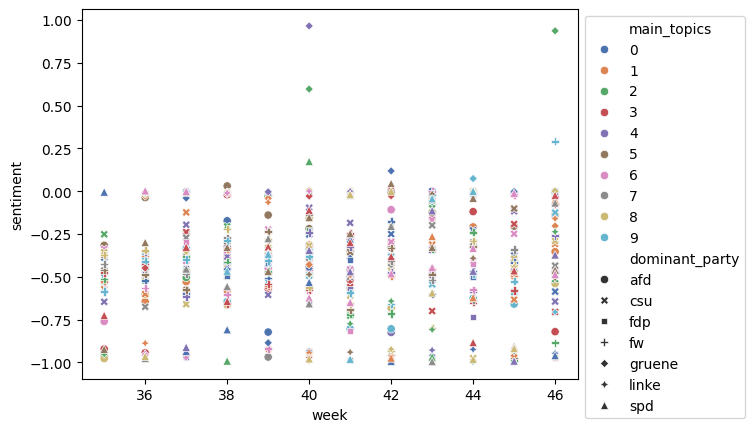

In [16]:
german_sentiment_df_p = (
    german_sentiment_df[["dominant_party", "week", "sentiment", "main_topics"]]
    .groupby(by=["dominant_party", "week", "main_topics"])
    .mean()
)
ax = sns.scatterplot(
    data=german_sentiment_df_p, x="week", y="sentiment", hue="main_topics", style="dominant_party", palette="deep"
)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

In [17]:
def get_most_important_word(model: gensim.models.LdaModel) -> dict[int, str]:
    """
    Get the most important words of a given model.

    There are to many topics with the same most important word therefore we use two.
    Alphabetical order!
    """
    return {x[0]: " ".join(sorted(x[1].split('"')[1:5:2])) for x in model.show_topics(num_words=2, num_topics=-1)}


get_most_important_word(lda_model)

{0: 'aiwanger bayern',
 1: 'afd aiwanger',
 2: 'afd aiwanger',
 3: 'aiwanger söder',
 4: 'aiwanger csu',
 5: 'aiwanger csu',
 6: 'afd bayern',
 7: 'aiwanger csu',
 8: 'aiwanger csu',
 9: 'aiwanger söder'}

In [18]:
german_sentiment_df_t = german_sentiment_df.copy()
german_sentiment_df_t["important_words"] = german_sentiment_df_t.main_topics.apply(
    lambda x: get_most_important_word(lda_model)[x]
)
german_sentiment_df_t.important_words.value_counts()

important_words
aiwanger csu       1966
aiwanger söder      954
afd aiwanger        657
aiwanger bayern     548
afd bayern          478
Name: count, dtype: int64

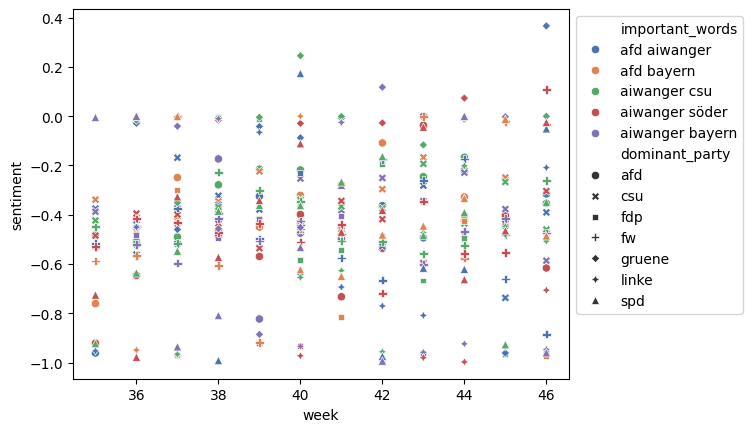

In [19]:
german_sentiment_df_t = (
    german_sentiment_df_t[["dominant_party", "week", "sentiment", "important_words"]]
    .groupby(by=["dominant_party", "week", "important_words"])
    .mean()
)
ax = sns.scatterplot(
    data=german_sentiment_df_t, x="week", y="sentiment", hue="important_words", style="dominant_party", palette="deep"
)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

In [20]:
profile = ProfileReport(
    german_sentiment_df,
    title="Profiling Report",
    correlations={
        "auto": {"calculate": True},
        "pearson": {"calculate": True},
        "spearman": {"calculate": True},
        "kendall": {"calculate": True},
        "phi_k": {"calculate": True},
        "cramers": {"calculate": True},
    },
    interactions=None,
    duplicates=None,
    samples=None,
)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Seeing the phi_k correlation measure, there is a medium correlation between dominant party and topic. Which makes sense, the party names and their candidate names are contained in the most important terms for some topics! 
The sentiment seam to be weakly or not correlated.

The word cloud of the original data, shows how import it is to remove stop words, as the most frequent terms as connotations and article do not have any meaning.


## LDA - Topics

The actual topic index, may change a possible, tested result is for 15 topics:
Some Topics form cluster. The main cluster consists of the topics 1-6, 8, 10, 12 (Bavaria, CSU, Söder, AFD). A smaller cluster is 7 & 9 (CSU).

The weighting factor λ is applied to rank the terms. λ = 1, means ranking of terms in decreasing order of their *topic*-specific probability and λ = 0 ranking by lift (term probability within a topic over its marginal probability across the corpus). Meaning, λ = 1 favours total probability with the corpus and λ = 0 favours the probability with the current text (see https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf).

The clusters 11 (Freie Wähler, CSU), 13 (Söder, Bayern, AFD), 14 (Söder, Bayern) and 15 (Bayern) are isolated.
The most import terms are:

| Topic | Percentage | λ = 0                                                     | λ = 0.5                          | λ = 1                            |
|-------|-----------:|-----------------------------------------------------------|----------------------------------|----------------------------------|
| 1     |        9.8 | Nazi, Augsburg                                            | CSU                              | CSU                              |
| 2     |        8.9 | 1, 25                                                     | Söder, CSU                       | Söder, CSU                       |
| 3     |        7.8 | Prozent                                                   | AFD, Bayern                      | AFD, Bayern                      |
| 4     |        7.7 | Hessen, Wählen (elect)                                    | Söder, Bayern                    | Söder, Bayern                    |
| 5     |        7.2 | Landtag (state parliament), Landtagswahl (state election) | AFD, Söder, Bayern               | AFD, Söder, Bayern               |
| 6     |        7.1 | ltbwby23                                                  | CSU, Bayern                      | CSU, Bayern                      |
| 7     |        7.0 | werfen (through)                                          | CSU, Söder                       | CSU, Söder                       |
| 8     |        6.9 | *laughing emojis*, Isral, letzter (last)                  | CSU, Söder                       | CSU, Söder                       |
| 9     |        6.4 | DE, Fakt (fact)                                           | CSU                              | CSU, CDU                         |
| 10    |        5.8 | Welt (world), Opfer (victim)                              | Hubert, Söder                    | Hubert, Söder                    |
| 11    |        5.5 | Freie Wähler                                              | Freie Wähler, Hubert, CSU, Söder | Freie Wähler, CSU, Hubert, Söder |
| 12    |        5.2 | Hartmann                                                  | CSU, Bayern, AFD                 | CSU, Bayern, AFD                 |
| 13    |        5.0 | wissen (know, knowledge)                                  | Söder, Bayern, CSU               | Söder, Bayern, CSU               |
| 14    |        4.9 | Hubsi (nickname of Hubert Aiwanger), Augsburg             | Söder, Augsburg, Bayern          | Söder, Bayern                    |
| 15    |        4.7 | 2, FDP                                                    | Bayern                           | Bayern                           |

## LDA for each party (with up to 15 topics)

When several topics are attributed to a document. How strong the attribution is given by a ratio. The sum of these ratios per document is 1.
We attribute each document with its strongest associated topic. Therefore, some topics are not included in the main_topics series.


In [22]:
# Create Widgets
w_party = widgets.Select(
    options=sorted(parties),
    value="csu",
    description="Party:",
    disabled=False,
)
w_n = widgets.IntSlider(
    value=7,
    min=2,
    max=15,
    step=1,
    description="Topics:",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format="d",
)

# Display Widgets


def update(selected_party: str, _num_topics: int) -> None:
    """Event to recompute the LDA when updating the number of TOPIC and the party."""
    print(f"Selected Party: {selected_party}")
    print(f"Number of Topics: {_num_topics}")

    _id2word = corpora.Dictionary(party_texts[selected_party])
    party_df = german_sentiment_df[german_sentiment_df.dominant_party == selected_party]
    _id2word.filter_extremes(no_below=15, no_above=0.50, keep_n=10000)

    # Term Document Frequency
    # Converts a collection of words to  a list of (word_id, word_frequency) 2-tuples.
    _corpus = [_id2word.doc2bow(text) for text in party_texts[w_party.value]]

    _lda_model = get_model(_corpus=_corpus, _id2word=id2word, _num_topics=_num_topics, random_state=2)
    lda_vis_prepared = pyLDAvis.gensim_models.prepare(_lda_model, corpus, id2word)
    display(lda_vis_prepared)

    fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True, sharex=True)

    party_topics = list(_lda_model.get_document_topics(_corpus))
    party_df.loc[:, "main_topics"] = [get_main_topic(x) for x in party_topics]
    ax1 = sns.scatterplot(
        data=party_df, x="week", y="sentiment", hue="main_topics", style="dominant_party", ax=axes[0], palette="deep"
    )
    ax1.set_title("Scatterplot 1: Sentiment by Main Topics")
    ax1.legend(loc="upper left", bbox_to_anchor=(1, 1))

    party_df.loc[:, "important_word"] = party_df.main_topics.apply(lambda x: get_most_important_word(_lda_model)[x])
    party_df = (
        party_df[["dominant_party", "week", "sentiment", "important_word"]]
        .groupby(by=["dominant_party", "week", "important_word"])
        .mean()
    )
    ax2 = sns.scatterplot(
        data=party_df, x="week", y="sentiment", hue="important_word", style="dominant_party", ax=axes[1], palette="deep"
    )
    ax2.set_title("Scatterplot 2: Mean Sentiment by Most important word!")
    ax2.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    display(plt.show())


interact(update, selected_party=w_party, _num_topics=w_n)

interactive(children=(Select(description='Party:', index=1, options=('afd', 'csu', 'fdp', 'fw', 'gruene', 'lin…

<function __main__.update(selected_party: str, _num_topics: int) -> None>

Computation of the LDA for the party `Die Linke` does not work.
Many (most) topics share the same most important term.

Because my topics share the same most important word, we use the two most import words (in alphabetical order). This increases the number of topics with unique most import words, while the most import words stay distinguishable.

Interesting most important words are:
- CSU: (braun, Söder), (frage, mehrere)
- FDP: (dienen, Söder), (Bundesregierung, dienen)
- Freie Wähler: (koalition, nazi)
- SPD: (dienen, Söder), (Aiwanger, Kampagne), (Aiwanger, jung)

As these terms are a good summary of the most important discussions. As minister Aiwanger did have a Nazi pamphlet in his school bag when he was young. Prime minister Söder did have several questions, about that, that ha to be answered. 

## Conclusion

Contrary to our hopes, there is no correlation between the topics and the sentiment.
This might be caused, by the fact that topics are very similar, or that we attribute posts to a party by its dominant party.